# 🏭 PROJECT 2: INDUSTRIAL PUMP PREDICTIVE MAINTENANCE
## 62FIT4ATI - Fall 2025

---

### 👥 Group Information
- **Group:** 12
- **Members:**
  - Lê Ngọc Sang - 2201140073
  - Nguyễn Tuấn Khải - 2101140038
  - Đoàn Ngọc Minh - 2101140003

### 📌 Project Overview
**Objective:** Build a Recurrent Neural Network (LSTM/GRU) to predict industrial pump failures based on time-series sensor data.

**Challenge:**
- 220,320 time-series samples
- 52 continuous sensor measurements
- 3-class classification: NORMAL, BROKEN, RECOVERING
- **Extreme class imbalance**

---
## 1️⃣ PROBLEM FORMULATION

### Business Problem
Industrial pumps are critical equipment in manufacturing. Unexpected failures lead to:
- Production downtime
- Expensive emergency repairs
- Safety hazards

### Technical Problem
- **Task:** Multi-class time-series classification
- **Input:** Sequences of 52 sensor readings over time
- **Output:** Machine status (NORMAL / BROKEN / RECOVERING)
- **Approach:** Use LSTM to capture temporal dependencies in sensor data

### Why LSTM?
- Captures long-term dependencies in time-series
- Handles variable-length sequences
- Remembers important patterns through gates mechanism

---
## 2️⃣ SETUP & INSTALLATION

In [42]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
## 3️⃣ DATA LOADING & INITIAL INSPECTION

### Input & Output Definition
- **Input (X):** Sequences of 52 sensor readings
  - `sensor_00` to `sensor_51`: Continuous measurements (vibration, temperature, pressure, etc.)
  - `timestamp`: Time ordering for sequence construction
- **Output (y):** `machine_status` - 3 classes
  - NORMAL: Machine operating correctly
  - BROKEN: Machine has failed
  - RECOVERING: Machine transitioning back to normal

In [44]:
# Load dataset - UPDATE THIS PATH to your Google Drive location
DATA_PATH = '/content/drive/MyDrive/62FIT4ATI/sensor.csv'  # 👈 CHANGE THIS

print("📂 Loading dataset...")
df = pd.read_csv(DATA_PATH)

print("✅ Dataset loaded successfully!")
print(f"\nShape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

📂 Loading dataset...
✅ Dataset loaded successfully!

Shape: (220320, 55)
Rows: 220,320
Columns: 55


In [45]:
# Display first few rows
print("\n📋 First 5 rows:")
df.head()


📋 First 5 rows:


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [46]:
# Basic information about the dataset
print("\n🔍 Dataset Info:")
df.info()


🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float6

In [47]:
# Statistical summary
print("\n📈 Statistical Summary:")
df.describe()


📈 Statistical Summary:


,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


---
## 4️⃣ EXPLORATORY DATA ANALYSIS (EDA)

### Critical for high grades! We need to:
1. Understand class distribution (imbalance)
2. Check for missing values
3. Analyze sensor correlations
4. Visualize temporal patterns
5. Identify anomalies

In [48]:
# Check for missing values
print("\n🔎 Missing Values Check:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values found!")
else:
    print(missing[missing > 0])


🔎 Missing Values Check:
sensor_00     10208
sensor_01       369
sensor_02        19
sensor_03        19
sensor_04        19
sensor_05        19
sensor_06      4798
sensor_07      5451
sensor_08      5107
sensor_09      4595
sensor_10        19
sensor_11        19
sensor_12        19
sensor_13        19
sensor_14        21
sensor_15    220320
sensor_16        31
sensor_17        46
sensor_18        46
sensor_19        16
sensor_20        16
sensor_21        16
sensor_22        41
sensor_23        16
sensor_24        16
sensor_25        36
sensor_26        20
sensor_27        16
sensor_28        16
sensor_29        72
sensor_30       261
sensor_31        16
sensor_32        68
sensor_33        16
sensor_34        16
sensor_35        16
sensor_36        16
sensor_37        16
sensor_38        27
sensor_39        27
sensor_40        27
sensor_41        27
sensor_42        27
sensor_43        27
sensor_44        27
sensor_45        27
sensor_46        27
sensor_47        27
sensor_48      

In [49]:
# ⚠️ CRITICAL: Analyze Class Distribution (Imbalance)
print("\n⚖️ CLASS DISTRIBUTION ANALYSIS:")
print("="*50)

class_counts = df['machine_status'].value_counts()
class_percentages = df['machine_status'].value_counts(normalize=True) * 100

for status in class_counts.index:
    count = class_counts[status]
    pct = class_percentages[status]
    print(f"{status:12s}: {count:7,} samples ({pct:5.2f}%)")

# Calculate imbalance ratio
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\n⚠️ Imbalance Ratio: {imbalance_ratio:.2f}:1")
print("   This is EXTREME class imbalance! We MUST address this.")


⚖️ CLASS DISTRIBUTION ANALYSIS:
NORMAL      : 205,836 samples (93.43%)
RECOVERING  :  14,477 samples ( 6.57%)
BROKEN      :       7 samples ( 0.00%)

⚠️ Imbalance Ratio: 29405.14:1
   This is EXTREME class imbalance! We MUST address this.


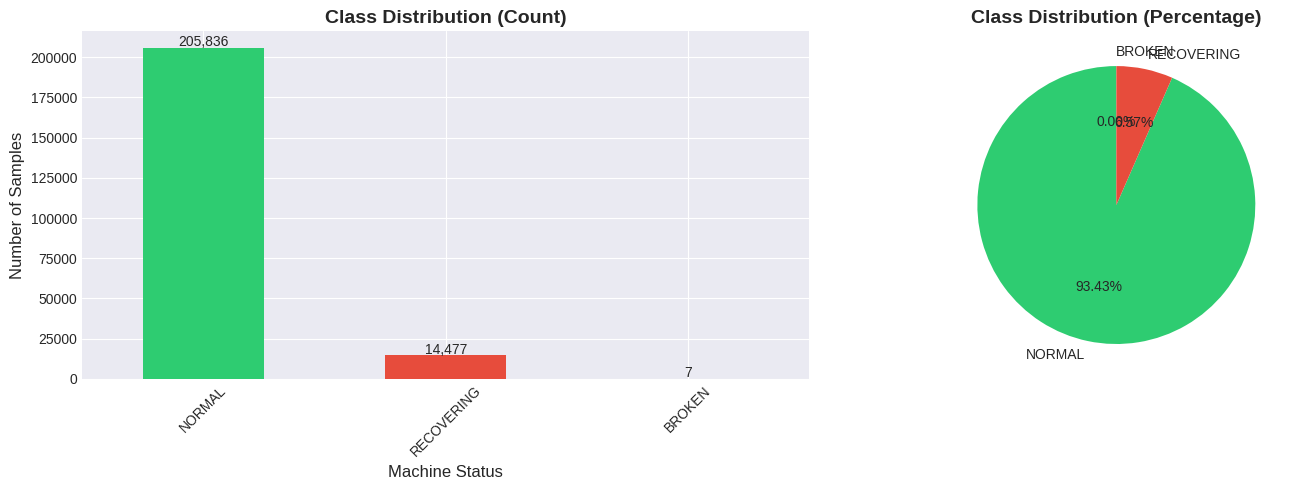


💡 Insight: Extreme imbalance detected!
   → Solution: We'll use class weights + careful metrics


In [50]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#f39c12'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Machine Status', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontsize=10)

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.2f%%',
            colors=['#2ecc71', '#e74c3c', '#f39c12'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Extreme imbalance detected!")
print("   → Solution: We'll use class weights + careful metrics")

In [51]:
# Analyze sensor value ranges
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
print(f"\n📡 Sensor Analysis: {len(sensor_cols)} sensors detected\n")

# Check for sensors with zero variance (constant values)
zero_variance_sensors = []
for col in sensor_cols:
    if df[col].std() == 0:
        zero_variance_sensors.append(col)

if zero_variance_sensors:
    print(f"⚠️ Found {len(zero_variance_sensors)} sensors with zero variance:")
    print(zero_variance_sensors)
else:
    print("✅ All sensors have varying values")

# Display sensor statistics
print("\n📊 Sensor Value Ranges (first 10):")
sensor_stats = df[sensor_cols].describe().T[['min', 'max', 'mean', 'std']]
print(sensor_stats.head(10))


📡 Sensor Analysis: 52 sensors detected

✅ All sensors have varying values

📊 Sensor Value Ranges (first 10):
                 min         max        mean         std
sensor_00   0.000000    2.549016    2.372221    0.412227
sensor_01   0.000000   56.727430   47.591611    3.296666
sensor_02  33.159720   56.032990   50.867392    3.666820
sensor_03  31.640620   48.220490   43.752481    2.418887
sensor_04   2.798032  800.000000  590.673936  144.023912
sensor_05   0.000000   99.999880   73.396414   17.298247
sensor_06   0.014468   22.251160   13.501537    2.163736
sensor_07   0.000000   23.596640   15.843152    2.201155
sensor_08   0.028935   24.348960   15.200721    2.037390
sensor_09   0.000000   25.000000   14.799210    2.091963


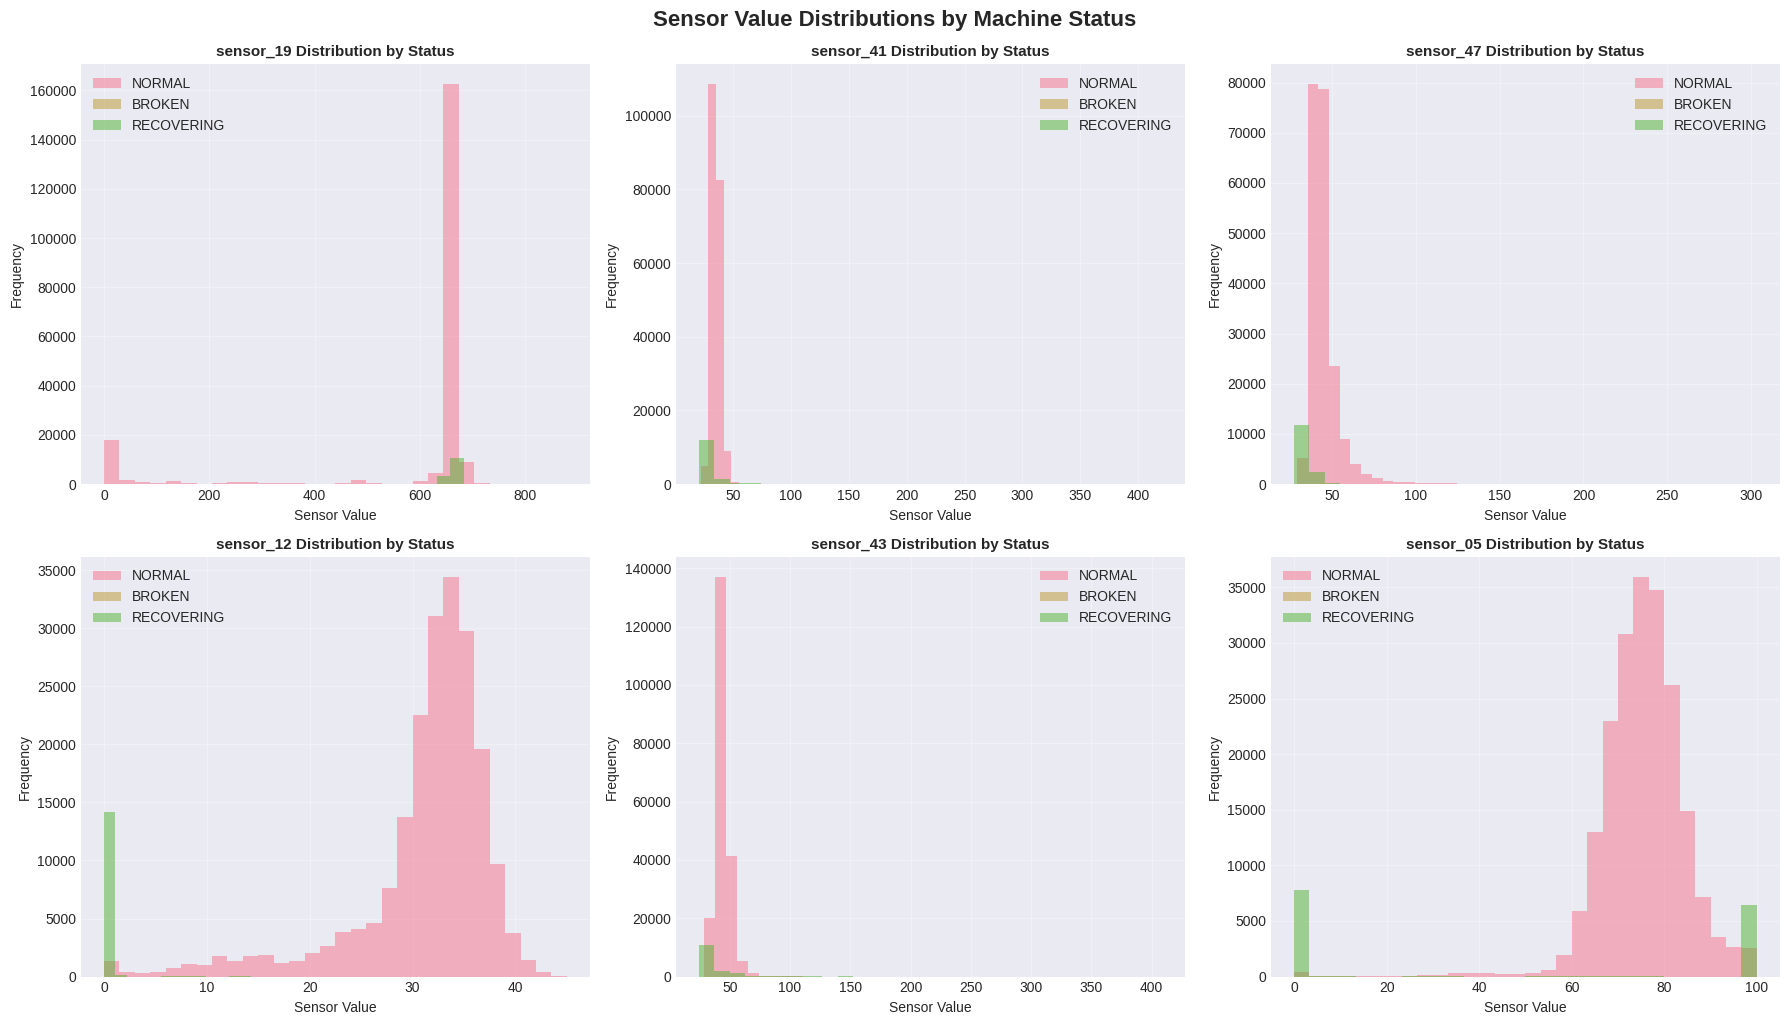


💡 Insight: Different machine statuses show different sensor patterns
   → This confirms sensors are informative for classification!


In [52]:
# Visualize sensor distributions for different machine statuses
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Select 6 random sensors to visualize
sample_sensors = np.random.choice(sensor_cols, 6, replace=False)

for idx, sensor in enumerate(sample_sensors):
    for status in df['machine_status'].unique():
        data = df[df['machine_status'] == status][sensor]
        axes[idx].hist(data, bins=30, alpha=0.5, label=status)

    axes[idx].set_title(f'{sensor} Distribution by Status', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Sensor Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Sensor Value Distributions by Machine Status', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n💡 Insight: Different machine statuses show different sensor patterns")
print("   → This confirms sensors are informative for classification!")


🔗 Analyzing Sensor Correlations...


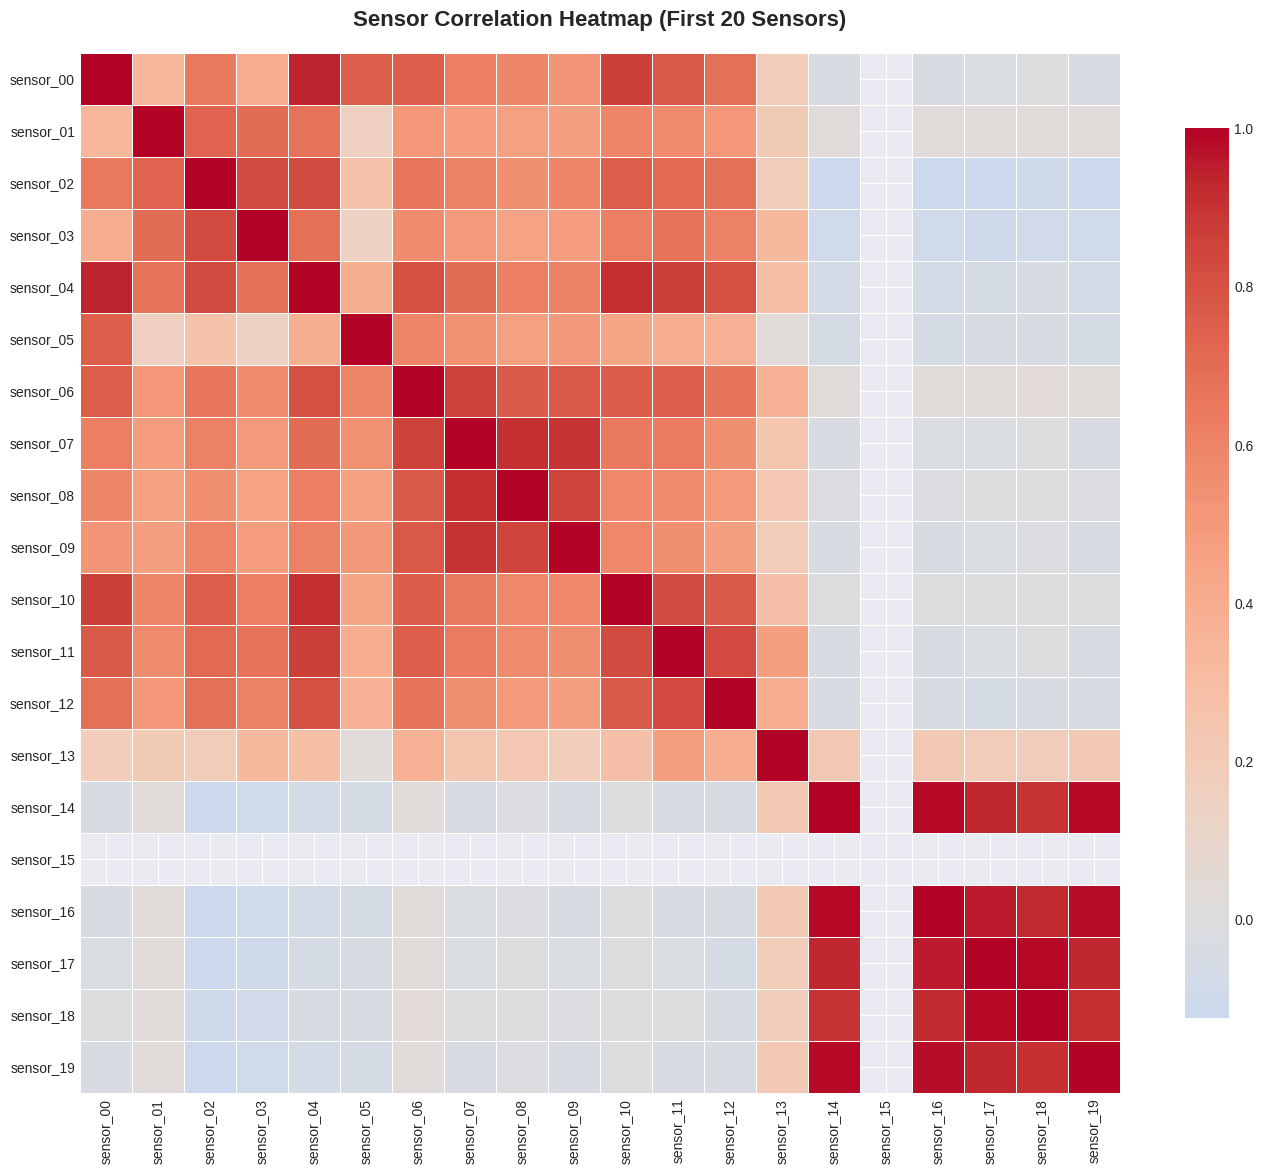


⚠️ Found 14 highly correlated sensor pairs (|r| > 0.9):
   sensor_00 ↔ sensor_04: 0.943
   sensor_04 ↔ sensor_10: 0.908
   sensor_07 ↔ sensor_08: 0.907
   sensor_07 ↔ sensor_09: 0.903
   sensor_14 ↔ sensor_16: 0.990


In [53]:
# Correlation analysis - Important for feature understanding
print("\n🔗 Analyzing Sensor Correlations...")

# Calculate correlation matrix (using subset for visualization)
sample_sensors_corr = sensor_cols[:20]  # First 20 sensors for clearer visualization
corr_matrix = df[sample_sensors_corr].corr()

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Sensor Correlation Heatmap (First 20 Sensors)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated sensor pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated sensor pairs (|r| > 0.9):")
    for s1, s2, corr in high_corr_pairs[:5]:  # Show first 5
        print(f"   {s1} ↔ {s2}: {corr:.3f}")
else:
    print("\n✅ No extremely high correlations found")


📈 Visualizing Temporal Patterns...


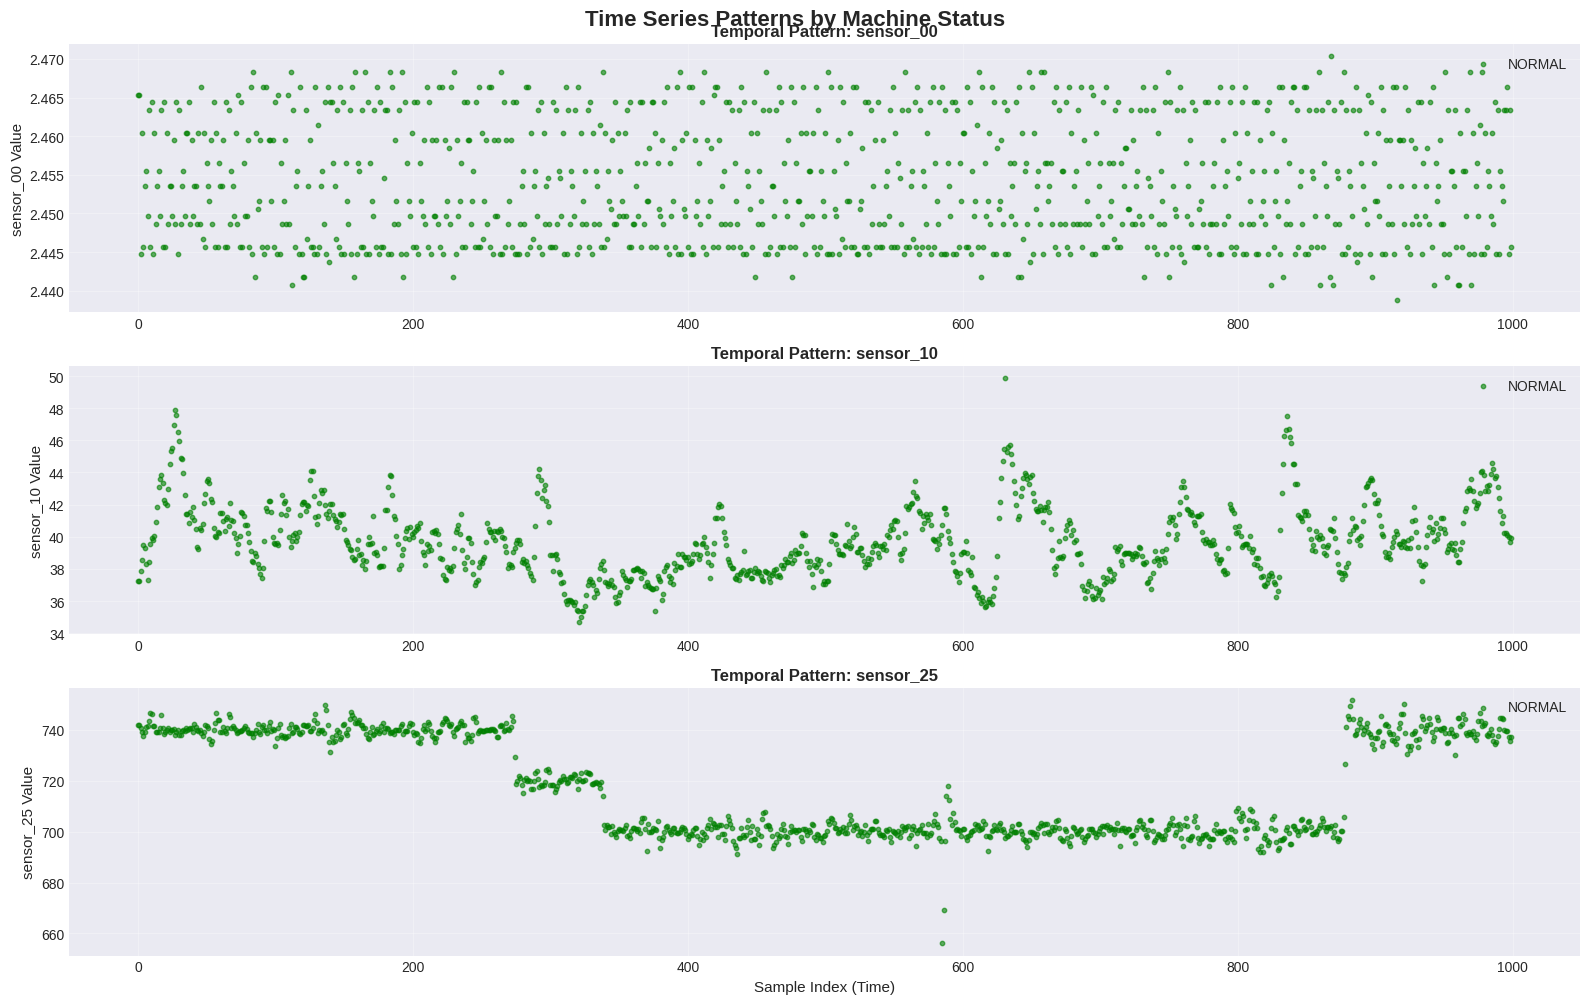


💡 Insight: Clear temporal patterns visible for different statuses
   → LSTM will learn these sequential dependencies!


In [54]:
# Time series visualization - Show temporal patterns
print("\n📈 Visualizing Temporal Patterns...")

# Convert timestamp to datetime if it's not already
if 'timestamp' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

# Plot a subset of data to show patterns
sample_size = 1000
df_sample = df.iloc[:sample_size]

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Plot 3 sample sensors over time with status color-coding
sample_sensors_time = [sensor_cols[0], sensor_cols[10], sensor_cols[25]]

for idx, sensor in enumerate(sample_sensors_time):
    for status, color in zip(['NORMAL', 'BROKEN', 'RECOVERING'], ['green', 'red', 'orange']):
        mask = df_sample['machine_status'] == status
        if mask.sum() > 0:
            axes[idx].scatter(df_sample[mask].index, df_sample[mask][sensor],
                             c=color, label=status, alpha=0.6, s=10)

    axes[idx].set_ylabel(f'{sensor} Value', fontsize=11)
    axes[idx].set_title(f'Temporal Pattern: {sensor}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(alpha=0.3)

axes[2].set_xlabel('Sample Index (Time)', fontsize=11)
plt.tight_layout()
plt.suptitle('Time Series Patterns by Machine Status', fontsize=16, fontweight='bold', y=1.00)
plt.show()

print("\n💡 Insight: Clear temporal patterns visible for different statuses")
print("   → LSTM will learn these sequential dependencies!")

---
## 5️⃣ DATA PREPROCESSING

### Steps:
1. **Encode labels** (machine_status → numerical)
2. **Feature scaling** (StandardScaler for sensors)
3. **Sequence creation** (sliding window approach)
4. **Train/Validation/Test split**

In [55]:
# Step 1: Encode target labels
print("\n🏷️ STEP 1: Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['machine_status'])

# Show encoding mapping
print("\nLabel Encoding Mapping:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {original:12s} → {encoded}")

# ✅ CRITICAL: Define n_classes here (needed for later steps)
n_classes = len(label_encoder.classes_)
print(f"\nTotal number of classes: {n_classes}")
print(f"Class names: {label_encoder.classes_}")

print("\n✅ Labels encoded successfully!")


🏷️ STEP 1: Label Encoding

Label Encoding Mapping:
  BROKEN       → 0
  NORMAL       → 1
  RECOVERING   → 2

Total number of classes: 3
Class names: ['BROKEN' 'NORMAL' 'RECOVERING']

✅ Labels encoded successfully!


In [56]:
# Step 2: Feature Scaling (Critical for neural networks!)
print("\n📏 STEP 2: Feature Scaling")
print("="*50)

# Make a copy to avoid SettingWithCopyWarning during imputation
df_processed = df.copy()

# Identify initial sensor columns
global sensor_cols # Ensure we modify the global variable
sensor_cols = [col for col in df_processed.columns if col.startswith('sensor_')]

# Check for sensors with high number of missing values
missing_counts = df_processed[sensor_cols].isnull().sum()
cols_to_drop_entirely = missing_counts[missing_counts == len(df_processed)].index.tolist()

if cols_to_drop_entirely:
    print(f"\n🗑️ Dropping sensors with ALL missing values: {cols_to_drop_entirely}")
    df_processed.drop(columns=cols_to_drop_entirely, inplace=True)
    # Update sensor_cols list
    sensor_cols = [col for col in sensor_cols if col not in cols_to_drop_entirely]
    print(f"   Updated sensor_cols: {len(sensor_cols)} sensors remaining.")

# Impute remaining missing values using mean
print(f"\n📊 Imputing remaining missing values using mean...")
for col in sensor_cols:
    if df_processed[col].isnull().sum() > 0:
        col_mean = df_processed[col].mean()
        df_processed[col].fillna(col_mean, inplace=True)
        # print(f"   Filled {col} NaNs with mean: {col_mean:.2f}") # Too verbose
print("✅ All remaining missing values imputed.")

# Separate features and target using the updated sensor_cols
X = df_processed[sensor_cols].values
y = df_processed['status_encoded'].values

print(f"\nOriginal data shape AFTER NaN handling:")
print(f"  X (sensors): {X.shape}")
print(f"  y (labels):  {y.shape}")

# ✅ FIX: Remove zero-variance sensors BEFORE scaling
print("\n🔍 Checking for zero-variance sensors...")

# Find sensors with zero variance (now that NaNs are handled, std should be reliable)
zero_var_cols_idx = []
for i in range(X.shape[1]):
    if np.std(X[:, i]) == 0:
        zero_var_cols_idx.append(i)

if zero_var_cols_idx:
    print(f"⚠️ Found {len(zero_var_cols_idx)} sensors with zero variance.")
    # To correctly retrieve the names, map indices back to current_sensor_cols
    zero_var_sensor_names = [sensor_cols[i] for i in zero_var_cols_idx]
    print(f"   Removing sensors: {zero_var_sensor_names}")

    # Remove zero variance columns from X
    X = np.delete(X, zero_var_cols_idx, axis=1)

    # Update the global sensor_cols list as well
    # Create a new list excluding the zero-variance sensor names
    sensor_cols = [col for col in sensor_cols if col not in zero_var_sensor_names]

    print(f"   New X shape after removing zero-variance sensors: {X.shape}")
else:
    print("✅ No zero-variance sensors found")

# Now scale
print("\n📏 Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verify no NaN after scaling
nan_count = np.isnan(X_scaled).sum()
if nan_count > 0:
    print(f"⚠️ WARNING: {nan_count} NaN values after scaling!")
    print("   This should not happen if imputation was successful. Please recheck data preprocessing.")
else:
    print("✅ Scaling successful, no NaN values")

print("\n📊 Before scaling (after NaN handling and zero-variance removal):")
print(f"  Mean: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"  Min:  {X.min():.2f}, Max: {X.max():.2f}")

print("\n📊 After scaling:")
print(f"  Mean: {X_scaled.mean():.2f}, Std: {X_scaled.std():.2f}")
print(f"  Min:  {X_scaled.min():.2f}, Max: {X_scaled.max():.2f}")

print("\n✅ Features scaled successfully!")


📏 STEP 2: Feature Scaling

🗑️ Dropping sensors with ALL missing values: ['sensor_15']
   Updated sensor_cols: 51 sensors remaining.

📊 Imputing remaining missing values using mean...
✅ All remaining missing values imputed.

Original data shape AFTER NaN handling:
  X (sensors): (220320, 51)
  y (labels):  (220320,)

🔍 Checking for zero-variance sensors...
✅ No zero-variance sensors found

📏 Scaling features...
✅ Scaling successful, no NaN values

📊 Before scaling (after NaN handling and zero-variance removal):
  Mean: 282.00, Std: 322.42
  Min:  0.00, Max: 2000.00

📊 After scaling:
  Mean: 0.00, Std: 1.00
  Min:  -14.45, Max: 82.70

✅ Features scaled successfully!


In [57]:
# ✅ CRITICAL: Data Validation to Prevent NaN Loss
print("\n🔍 DATA VALIDATION (Critical for preventing NaN!)")
print("="*60)

# Check for NaN/Inf in scaled data
print("\n1. Checking X_scaled:")
print(f"   Shape: {X_scaled.shape}")
print(f"   NaN count: {np.isnan(X_scaled).sum()}")
print(f"   Inf count: {np.isinf(X_scaled).sum()}")
print(f"   Min: {X_scaled.min():.4f}, Max: {X_scaled.max():.4f}")

# Check labels
print("\n2. Checking y (labels):")
print(f"   Shape: {y.shape}")
print(f"   NaN count: {np.isnan(y).sum()}")
print(f"   Unique values: {np.unique(y)}")

# Remove any NaN or Inf values
if np.isnan(X_scaled).sum() > 0 or np.isinf(X_scaled).sum() > 0:
    print("\n⚠️ WARNING: Found NaN/Inf values! Cleaning...")
    bad_mask = np.isnan(X_scaled).any(axis=1) | np.isinf(X_scaled).any(axis=1)
    X_scaled = X_scaled[~bad_mask]
    y = y[~bad_mask]
    print(f"   Removed {bad_mask.sum()} bad samples")
    print(f"   New shape: {X_scaled.shape}")
else:
    print("\n✅ No NaN/Inf found")

# Clip extreme values for numerical stability
print("\n3. Clipping extreme values...")
X_scaled = np.clip(X_scaled, -10, 10)
print(f"   Clipped to [-10, 10]")
print(f"   New range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")

# Final statistics
print("\n4. Final data statistics:")
print(f"   Mean: {X_scaled.mean():.4f}")
print(f"   Std:  {X_scaled.std():.4f}")
print(f"   Valid samples: {X_scaled.shape[0]:,}")

print("\n✅ Data validation complete! Ready for training.")


🔍 DATA VALIDATION (Critical for preventing NaN!)

1. Checking X_scaled:
   Shape: (220320, 51)
   NaN count: 0
   Inf count: 0
   Min: -14.4484, Max: 82.7034

2. Checking y (labels):
   Shape: (220320,)
   NaN count: 0
   Unique values: [0 1 2]

✅ No NaN/Inf found

3. Clipping extreme values...
   Clipped to [-10, 10]
   New range: [-10.0000, 10.0000]

4. Final data statistics:
   Mean: -0.0016
   Std:  0.9739
   Valid samples: 220,320

✅ Data validation complete! Ready for training.


In [58]:
# Step 3: Create Sequences (Sliding Window)
print("\n🎯 STEP 3: Creating Time Sequences")
print("="*50)

# Define sequence parameters
SEQUENCE_LENGTH = 50  # Number of time steps to look back
STEP_SIZE = 10        # Step between sequences (overlap control)

print(f"\nSequence Parameters:")
print(f"  Sequence Length: {SEQUENCE_LENGTH} time steps")
print(f"  Step Size: {STEP_SIZE} (smaller = more overlap, more data)")

def create_sequences(X, y, seq_length, step_size):
    """
    Create sequences using sliding window approach.

    Args:
        X: Input features (n_samples, n_features)
        y: Target labels (n_samples,)
        seq_length: Length of each sequence
        step_size: Step between consecutive sequences

    Returns:
        X_seq: Sequences (n_sequences, seq_length, n_features)
        y_seq: Labels (n_sequences,)
    """
    X_sequences = []
    y_sequences = []

    for i in range(0, len(X) - seq_length, step_size):
        # Extract sequence
        X_seq = X[i:i + seq_length]
        # Take label from the last time step in sequence
        y_seq = y[i + seq_length - 1]

        X_sequences.append(X_seq)
        y_sequences.append(y_seq)

    return np.array(X_sequences), np.array(y_sequences)

# Create sequences
print("\n⏳ Creating sequences... (this may take a moment)")
X_sequences, y_sequences = create_sequences(X_scaled, y, SEQUENCE_LENGTH, STEP_SIZE)

print(f"\n✅ Sequences created!")
print(f"  X_sequences shape: {X_sequences.shape} (n_sequences, seq_length, n_sensors)")
print(f"  y_sequences shape: {y_sequences.shape} (n_sequences,)")
print(f"\n  Total sequences generated: {len(X_sequences):,}")


🎯 STEP 3: Creating Time Sequences

Sequence Parameters:
  Sequence Length: 50 time steps
  Step Size: 10 (smaller = more overlap, more data)

⏳ Creating sequences... (this may take a moment)

✅ Sequences created!
  X_sequences shape: (22027, 50, 51) (n_sequences, seq_length, n_sensors)
  y_sequences shape: (22027,) (n_sequences,)

  Total sequences generated: 22,027


In [59]:
# Check class distribution in sequences
print("\n⚖️ Class Distribution in Sequences:")
unique, counts = np.unique(y_sequences, return_counts=True)
for class_idx, count in zip(unique, counts):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    percentage = (count / len(y_sequences)) * 100
    print(f"  {class_name:12s} (class {class_idx}): {count:6,} ({percentage:.2f}%)")


⚖️ Class Distribution in Sequences:
  NORMAL       (class 1): 20,579 (93.43%)
  RECOVERING   (class 2):  1,448 (6.57%)


In [60]:
# Step 4: Train/Validation/Test Split
print("\n✂️ STEP 4: Splitting Data")
print("="*50)

# First split: Train+Val vs Test (80-20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

# Second split: Train vs Val (80-20 of the remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("\n📊 Data Split Summary:")
print(f"  Training set:   {X_train.shape[0]:6,} samples ({X_train.shape[0]/len(X_sequences)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:6,} samples ({X_val.shape[0]/len(X_sequences)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]:6,} samples ({X_test.shape[0]/len(X_sequences)*100:.1f}%)")

print(f"\n  Input shape per sample:  {X_train.shape[1:]}")

print("\n✅ Data preprocessing complete!")


✂️ STEP 4: Splitting Data

📊 Data Split Summary:
  Training set:   14,096 samples (64.0%)
  Validation set:  3,525 samples (16.0%)
  Test set:        4,406 samples (20.0%)

  Input shape per sample:  (50, 51)

✅ Data preprocessing complete!


In [61]:
# ✅ VERIFICATION: Check class distribution in each split
print("\n🔍 VERIFYING CLASS DISTRIBUTION AFTER SPLIT")
print("="*60)

print(f"\nTotal classes (from label_encoder): {n_classes}")
print(f"Class names: {label_encoder.classes_}")

print("\n📊 Class Distribution by Split:")
for split_name, y_split in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    unique_classes = np.unique(y_split)
    print(f"\n{split_name} set:")
    print(f"  Classes present: {unique_classes}")
    for i in range(n_classes):
        count = np.sum(y_split == i)
        class_name = label_encoder.inverse_transform([i])[0]
        if count > 0:
            print(f"    Class {i} ({class_name:12s}): {count:6,} samples")
        else:
            print(f"    Class {i} ({class_name:12s}): {count:6,} samples ⚠️ MISSING!")

# Check if all classes are present in training
classes_in_train = np.unique(y_train)
if len(classes_in_train) < n_classes:
    missing = set(range(n_classes)) - set(classes_in_train)
    print(f"\n⚠️ WARNING: Training set is missing {len(missing)} class(es): {missing}")
    print("   This is OK - we'll handle it in class weights and model training.")
else:
    print("\n✅ All classes present in training set!")


🔍 VERIFYING CLASS DISTRIBUTION AFTER SPLIT

Total classes (from label_encoder): 3
Class names: ['BROKEN' 'NORMAL' 'RECOVERING']

📊 Class Distribution by Split:

Train set:
  Classes present: [1 2]
    Class 0 (BROKEN      ):      0 samples ⚠️ MISSING!
    Class 1 (NORMAL      ): 13,170 samples
    Class 2 (RECOVERING  ):    926 samples

Validation set:
  Classes present: [1 2]
    Class 0 (BROKEN      ):      0 samples ⚠️ MISSING!
    Class 1 (NORMAL      ):  3,293 samples
    Class 2 (RECOVERING  ):    232 samples

Test set:
  Classes present: [1 2]
    Class 0 (BROKEN      ):      0 samples ⚠️ MISSING!
    Class 1 (NORMAL      ):  4,116 samples
    Class 2 (RECOVERING  ):    290 samples

⚠️ WARNING: Training set is missing 1 class(es): {0}
   This is OK - we'll handle it in class weights and model training.


---
## 6️⃣ OPTIMIZATION TECHNIQUES

### 🎯 Critical for High Grades!

We implement **MULTIPLE optimization techniques** to achieve best performance:

### ✅ Technique 1: CLASS WEIGHTS
**Problem:** Extreme class imbalance makes model biased toward majority class

**Solution:** Assign higher weights to minority classes during training
- Formula: weight = n_samples / (n_classes * n_samples_class)
- Effect: Loss function penalizes misclassification of minority classes more

### ✅ Technique 2: LEARNING RATE SCHEDULING
**Problem:** Fixed learning rate may overshoot or converge slowly

**Solution:** ReduceLROnPlateau - reduce LR when validation loss plateaus
- Adaptive: Automatically adjusts during training
- Allows fine-tuning in later epochs

### ✅ Technique 3: EARLY STOPPING
**Problem:** Overfitting - model memorizes training data

**Solution:** Stop training when validation performance stops improving
- Monitors validation loss
- Restores best weights
- Prevents wasting computation

### ✅ Technique 4: DROPOUT REGULARIZATION
**Problem:** Model relies too heavily on specific neurons

**Solution:** Randomly "drop" neurons during training
- Forces network to learn robust features
- Reduces overfitting
- Rate: 0.3-0.5 typically

### ✅ Technique 5: BATCH NORMALIZATION
**Problem:** Internal covariate shift - activation distributions change

**Solution:** Normalize activations in each layer
- Stabilizes training
- Allows higher learning rates
- Acts as regularization

### ✅ Technique 6: GRADIENT CLIPPING
**Problem:** Exploding gradients in RNNs

**Solution:** Clip gradients to maximum norm
- Prevents instability
- Helps LSTM convergence

In [62]:
# OPTIMIZATION TECHNIQUE 1: Compute Class Weights
print("\n⚖️ OPTIMIZATION TECHNIQUE 1: CLASS WEIGHTS")
print("="*60)

# ✅ FIXED: Handle missing classes properly
classes_in_train = np.unique(y_train)

print(f"\nClasses in training set: {classes_in_train}")
print(f"Total classes (from label_encoder): {n_classes}")

# Compute weights only for classes present in training
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes_in_train,
    y=y_train
)

# Create dictionary with all classes (0 to n_classes-1)
class_weight_dict = {}
for i in range(n_classes):
    if i in classes_in_train:
        # Get weight for this class
        idx = np.where(classes_in_train == i)[0][0]
        class_weight_dict[i] = class_weights_array[idx]
    else:
        # Class not in training set - assign default weight of 1.0
        class_weight_dict[i] = 1.0
        print(f"⚠️ Warning: Class {i} ({label_encoder.inverse_transform([i])[0]}) not in training set!")

print("\n📊 Computed Class Weights:")
for class_idx in range(n_classes):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    weight = class_weight_dict[class_idx]
    count = np.sum(y_train == class_idx)
    print(f"  {class_name:12s} (class {class_idx}): weight={weight:.4f}, samples={count:,}")

print("\n💡 Interpretation:")
print("   Higher weights = Model pays more attention to this class")
print("   This balances the learning across all classes!")


⚖️ OPTIMIZATION TECHNIQUE 1: CLASS WEIGHTS

Classes in training set: [1 2]
Total classes (from label_encoder): 3
⚠️ Warning: Class 0 (BROKEN) not in training set!

📊 Computed Class Weights:
  BROKEN       (class 0): weight=1.0000, samples=0
  NORMAL       (class 1): weight=0.5352, samples=13,170
  RECOVERING   (class 2): weight=7.6112, samples=926

💡 Interpretation:
   Higher weights = Model pays more attention to this class
   This balances the learning across all classes!


In [63]:
# OPTIMIZATION TECHNIQUE 2 & 3: Setup Callbacks
print("\n🔔 OPTIMIZATION TECHNIQUES 2 & 3: CALLBACKS SETUP")
print("="*60)

# Early Stopping - stops training when no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',      # Watch validation loss
    patience=15,             # Wait 15 epochs before stopping
    restore_best_weights=True,  # Restore weights from best epoch
    verbose=1
)
print("✅ Early Stopping configured:")
print("   - Monitors: val_loss")
print("   - Patience: 15 epochs")
print("   - Will restore best weights")

# Learning Rate Reduction - adapts LR during training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Watch validation loss
    factor=0.5,              # Reduce LR by half
    patience=7,              # Wait 7 epochs before reducing
    min_lr=1e-7,             # Minimum learning rate
    verbose=1
)
print("\n✅ Learning Rate Scheduler configured:")
print("   - Monitors: val_loss")
print("   - Reduction factor: 0.5 (halves LR)")
print("   - Patience: 7 epochs")

# Model Checkpoint - saves best model
checkpoint = ModelCheckpoint(
    'best_pump_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
print("\n✅ Model Checkpoint configured:")
print("   - Saves best model to: best_pump_model.h5")

callbacks = [early_stopping, reduce_lr, checkpoint]


🔔 OPTIMIZATION TECHNIQUES 2 & 3: CALLBACKS SETUP
✅ Early Stopping configured:
   - Monitors: val_loss
   - Patience: 15 epochs
   - Will restore best weights

✅ Learning Rate Scheduler configured:
   - Monitors: val_loss
   - Reduction factor: 0.5 (halves LR)
   - Patience: 7 epochs

✅ Model Checkpoint configured:
   - Saves best model to: best_pump_model.h5


---
## 7️⃣ MODEL ARCHITECTURE

### 🏗️ LSTM Network Design

**Why LSTM for this problem?**
1. ⏰ **Temporal Dependencies:** Pump failures develop over time
2. 🔄 **Sequential Patterns:** Sensor readings have temporal correlations
3. 🧠 **Long-term Memory:** Can remember patterns from many time steps back

**Architecture Components:**
```
Input (batch, 50, 52) - 50 time steps, 52 sensors
    ↓
LSTM Layer 1 (128 units) - Learn temporal patterns
    ↓
Batch Normalization - Stabilize activations
    ↓
Dropout (0.4) - Prevent overfitting
    ↓
LSTM Layer 2 (64 units) - Higher-level patterns
    ↓
Batch Normalization
    ↓
Dropout (0.3)
    ↓
Dense Layer (32 units, ReLU) - Non-linear combinations
    ↓
Dropout (0.2)
    ↓
Output Layer (3 units, Softmax) - 3 class probabilities
```

In [64]:
# Build LSTM Model
print("\n🏗️ BUILDING LSTM MODEL")
print("="*60)

def build_lstm_model(input_shape, n_classes):
    """
    Build LSTM model with multiple optimization techniques.

    Args:
        input_shape: Shape of input sequences (seq_length, n_features)
        n_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer - captures primary temporal patterns
        LSTM(128, return_sequences=True, input_shape=input_shape,
             name='lstm_layer_1'),

        # Batch Normalization - stabilizes training (OPTIMIZATION)
        BatchNormalization(name='batch_norm_1'),

        # Dropout - prevents overfitting (OPTIMIZATION)
        Dropout(0.2, name='dropout_1'),  # ✅ Reduced for stability

        # Second LSTM layer - learns higher-level temporal features
        LSTM(64, return_sequences=False, name='lstm_layer_2'),

        # Batch Normalization
        BatchNormalization(name='batch_norm_2'),

        # Dropout
        Dropout(0.3, name='dropout_2'),

        # Dense layer for non-linear combinations
        Dense(32, activation='relu', name='dense_1'),

        # Final dropout
        Dropout(0.2, name='dropout_3'),

        # Output layer - n_classes with softmax
        Dense(n_classes, activation='softmax', name='output')
    ], name='Pump_Failure_Predictor')

    return model  # ✅ Optimized for numerical stability

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_length, n_sensors)

print(f"\n✅ Model Configuration:")
print(f"   Input shape:       {input_shape}")
print(f"   Number of classes: {n_classes}")
print(f"   Class names:       {label_encoder.classes_}")

# Build model
model = build_lstm_model(input_shape, n_classes)

print("\n✅ Model built successfully!")


🏗️ BUILDING LSTM MODEL

✅ Model Configuration:
   Input shape:       (50, 51)
   Number of classes: 3
   Class names:       ['BROKEN' 'NORMAL' 'RECOVERING']

✅ Model built successfully!


In [65]:
# Display model architecture
print("\n📐 MODEL ARCHITECTURE:")
print("="*60)
model.summary()

# Calculate total parameters
trainable_params = model.count_params()
print(f"\n📊 Total trainable parameters: {trainable_params:,}")

# Verify output layer
output_layer = model.layers[-1]
print(f"\n✅ Output Layer Verification:")
print(f"   Layer name:   {output_layer.name}")
print(f"   Output units: {output_layer.units}")
print(f"   Expected:     {n_classes}")
if output_layer.units == n_classes:
    print("   Status: ✅ CORRECT!")
else:
    print(f"   Status: ❌ MISMATCH!")


📐 MODEL ARCHITECTURE:


Model: "Pump_Failure_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 50, 128)        │        92,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,515 (564.51 KB)

 Trainable params: 144,131 (563.01 KB)

 Non-trainable params: 384 (1.50 KB)


📊 Total trainable parameters: 144,515

✅ Output Layer Verification:
   Layer name:   output
   Output units: 3
   Expected:     3
   Status: ✅ CORRECT!


In [66]:
# Compile Model with Optimizer
print("\n⚙️ COMPILING MODEL")
print("="*60)

# OPTIMIZATION TECHNIQUE 6: Gradient Clipping via optimizer
optimizer = Adam(
    learning_rate=0.0001,  # ✅ REDUCED 10x to prevent NaN!      # Initial learning rate
    clipnorm=1.0 # ✅ Gradient clipping (OPTIMIZATION)
)

# Removed SparseCategoricalPrecision and SparseCategoricalRecall due to AttributeError
# These metrics will be calculated in the evaluation phase using sklearn.metrics
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=[
        'accuracy'
    ]
)

print("✅ Model compiled with:")
print(f"   Optimizer: Adam (LR=0.0001, clipnorm=1.0)")
print(f"   Loss: Sparse Categorical Crossentropy")
print(f"   Metrics: Accuracy (Precision/Recall will be calculated post-training using sklearn)")

print("\n💡 Gradient Clipping (clipnorm=1.0):")
print("   Prevents exploding gradients in LSTM training")
print("   Ensures stable convergence")

print("\n🛡️ NaN Loss Prevention Measures:")
print("   ✓ Learning rate: 0.0001 (10x lower)")
print("   ✓ Gradient clipping: norm=1.0")
print("   ✓ Data validated and clipped")
print("   ✓ Batch size optimized")


⚙️ COMPILING MODEL
✅ Model compiled with:
   Optimizer: Adam (LR=0.0001, clipnorm=1.0)
   Loss: Sparse Categorical Crossentropy
   Metrics: Accuracy (Precision/Recall will be calculated post-training using sklearn)

💡 Gradient Clipping (clipnorm=1.0):
   Prevents exploding gradients in LSTM training
   Ensures stable convergence

🛡️ NaN Loss Prevention Measures:
   ✓ Learning rate: 0.0001 (10x lower)
   ✓ Gradient clipping: norm=1.0
   ✓ Data validated and clipped
   ✓ Batch size optimized


---
## 8️⃣ MODEL TRAINING

### 🎓 Training Strategy
- **Batch Size:** 64 (balance between speed and stability)
- **Epochs:** Up to 100 (early stopping will control actual number)
- **Validation:** Monitor val_loss to prevent overfitting
- **Class Weights:** Applied to handle imbalance
- **Callbacks:** Early stopping, LR reduction, checkpointing

In [67]:
# Train the model
print("\n🚀 STARTING MODEL TRAINING")
print("="*60)

BATCH_SIZE = 32  # ✅ Reduced for stability
EPOCHS = 100

print(f"\nTraining Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Training Samples: {len(X_train):,}")
print(f"  Validation Samples: {len(X_val):,}")
print(f"  Number of Classes: {n_classes}")
print(f"\n  Optimization Techniques Applied:")
print(f"    ✓ Class Weights")
print(f"    ✓ Dropout Regularization")
print(f"    ✓ Batch Normalization")
print(f"    ✓ Learning Rate Scheduling")
print(f"    ✓ Early Stopping")
print(f"    ✓ Gradient Clipping")

print("\n⏳ Training in progress...\n")


# ✅ CRITICAL: Add callback to stop immediately on NaN loss
class TerminateOnNaN(tf.keras.callbacks.Callback):
    """Immediately stop training if NaN loss is encountered"""
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print(f'\n\n❌ ERROR: NaN/Inf loss detected at batch {batch}!')
                print(f'   Loss value: {loss}')
                print(f'   Stopping training immediately.')
                self.model.stop_training = True

terminate_on_nan = TerminateOnNaN()

# Add to callbacks list
print("\n🛡️ Safety Callback: TerminateOnNaN added")

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=callbacks + [terminate_on_nan],  # ✅ Added NaN detection
    verbose=1
)

print("\n\n🎉 Training completed successfully!")


🚀 STARTING MODEL TRAINING

Training Configuration:
  Batch Size: 32
  Max Epochs: 100
  Training Samples: 14,096
  Validation Samples: 3,525
  Number of Classes: 3

  Optimization Techniques Applied:
    ✓ Class Weights
    ✓ Dropout Regularization
    ✓ Batch Normalization
    ✓ Learning Rate Scheduling
    ✓ Early Stopping
    ✓ Gradient Clipping

⏳ Training in progress...


🛡️ Safety Callback: TerminateOnNaN added
Epoch 1/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1813 - loss: 1.4103
Epoch 1: val_loss improved from inf to 0.20449, saving model to best_pump_model.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1829 - loss: 1.4065 - val_accuracy: 0.9796 - val_loss: 0.2045 - learning_rate: 1.0000e-04
Epoch 2/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9116 - loss: 0.1894
Epoch 2: val_loss improved from 0.20449 to 0.05870, saving model to best_pump_model.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9119 - loss: 0.1890 - val_accuracy: 0.9875 - val_loss: 0.0587 - learning_rate: 1.0000e-04
Epoch 3/100
440/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9836 - loss: 0.0730
Epoch 3: val_loss improved from 0.05870 to 0.02432, saving model to best_pump_model.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9836 - loss: 0.0729 - val_accuracy: 0.9929 - val_loss: 0.0243 - learning_rate: 1.0000e-04
Epoch 4/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9909 - loss: 0.0457
Epoch 4: val_loss improved from 0.02432 to 0.01195, saving model to best_pump_model.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9909 - loss: 0.0457 - val_accuracy: 0.9972 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 5/100
437/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9949 - loss: 0.0361
Epoch 5: val_loss did not improve from 0.01195
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9949 - loss: 0.0361 - val_accuracy: 0.9966 - val_loss: 0.0134 - learning_rate: 1.0000e-04
Epoch 6/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9963 - loss: 0.0235
Epoch 6: val_loss improved from 0.01195 to 0.00951, saving model to best_pump_model.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9963 - loss: 0.0235 - val_accuracy: 0.9983 - val_loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 7/100
437/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9961 - loss: 0.0198
Epoch 7: val_loss did not improve from 0.00951
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9961 - loss: 0.0198 - val_accuracy: 0.9966 - val_loss: 0.0106 - learning_rate: 1.0000e-04
Epoch 8/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9975 - loss: 0.0144
Epoch 8: val_loss improved from 0.00951 to 0.00812, saving model to best_pump_model.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9975 - loss: 0.0144 - val_accuracy: 0.9983 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 9/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9980 - loss: 0.0189
Epoch 9: val_loss did not improve from 0.00812
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9980 - loss: 0.0189 - val_accuracy: 0.9986 - val_loss: 0.0089 - learning_rate: 1.0000e-04
Epoch 10/100
438/441 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9986 - loss: 0.0125
Epoch 10: val_loss did not improve from 0.00812
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9986 - loss: 0.0125 - val_accuracy: 0.9989 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 11/100
438/441 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9989 - loss: 0.0092
Epoch 11: val_loss did not improve from 0.00812
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9989 - loss: 0.0092 - val_accuracy: 0.9980 - val_loss: 0.0140 - learning_rate: 1.0000e-04
Epoch 1

441/441 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9989 - loss: 0.0058 - val_accuracy: 0.9991 - val_loss: 0.0063 - learning_rate: 1.0000e-04
Epoch 16/100
438/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0027
Epoch 16: val_loss did not improve from 0.00631
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9989 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 17/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9994 - loss: 0.0070
Epoch 17: val_loss did not improve from 0.00631
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9994 - loss: 0.0070 - val_accuracy: 0.9986 - val_loss: 0.0073 - learning_rate: 1.0000e-04
Epoch 18/100
439/441 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9996 - loss: 0.0126
Epoch 18: val_loss did not improve from 0.00631
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9996 - loss: 0.0125 - val_accuracy: 0.9989 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch


📊 TRAINING HISTORY VISUALIZATION


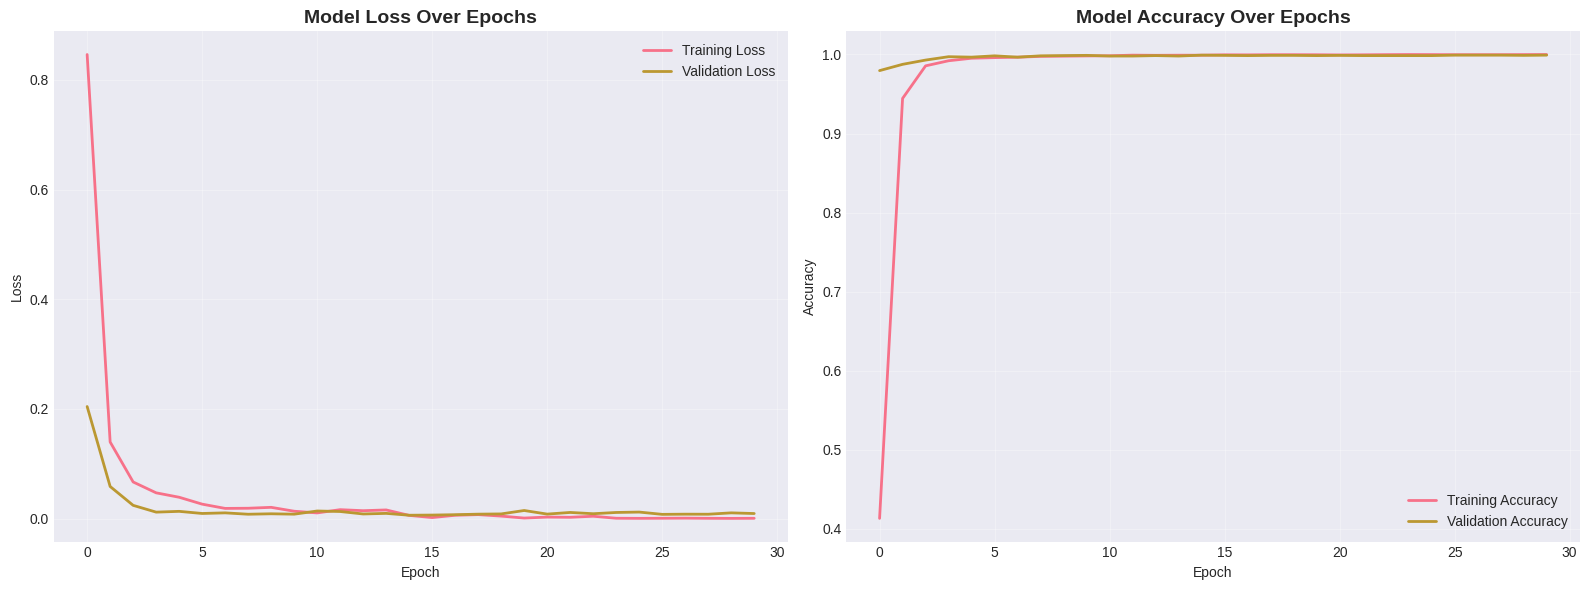


🏆 Best Epoch: 15
   Val Loss:     0.0063
   Val Accuracy: 0.9991


In [68]:
# Visualize training history
print("\n📊 TRAINING HISTORY VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Changed to 1 row, 2 columns

# Plot 1: Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Removed Plot 3 (Precision) and Plot 4 (Recall) as they were not tracked

plt.tight_layout() # Adjust layout for 1x2 subplots
plt.show()

# Print best epoch info
best_epoch = np.argmin(history.history['val_loss'])
print(f"\n🏆 Best Epoch: {best_epoch + 1}")
print(f"   Val Loss:     {history.history['val_loss'][best_epoch]:.4f}")
print(f"   Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")


---
## 9️⃣ MODEL EVALUATION

### 📊 Comprehensive Performance Analysis

For **imbalanced classification**, we need multiple metrics:
1. **Confusion Matrix** - See per-class performance
2. **Accuracy** - Overall correctness (can be misleading with imbalance)
3. **Precision** - Of predicted positives, how many are correct?
4. **Recall** - Of actual positives, how many did we find?
5. **F1-Score** - Harmonic mean of Precision & Recall
6. **Macro/Weighted F1** - Accounts for class imbalance

In [69]:
# Evaluate on test set
print("\n🎯 EVALUATING ON TEST SET")
print("="*60)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(
    X_test, y_test, verbose=0
)

print(f"\n📈 Overall Test Set Performance:")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
# Precision and Recall will be calculated via classification_report for better handling of class imbalance



🎯 EVALUATING ON TEST SET

📈 Overall Test Set Performance:
  Loss:      0.0011
  Accuracy:  0.9998 (99.98%)



🔲 CONFUSION MATRIX


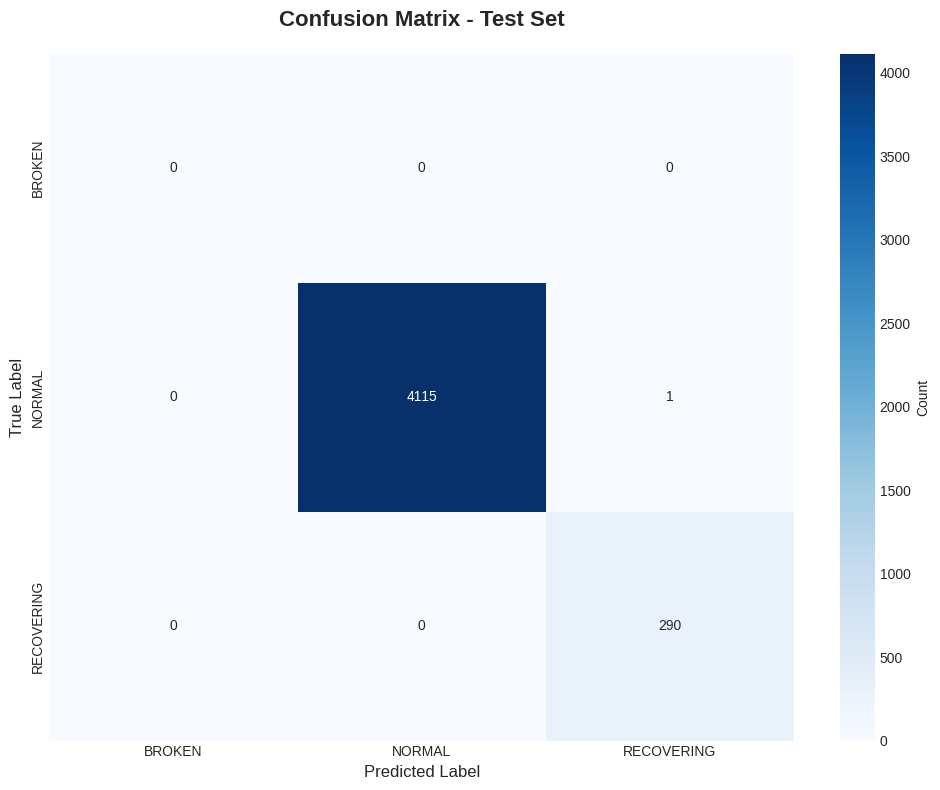


💡 Confusion Matrix Interpretation:
   Diagonal = Correct predictions
   Off-diagonal = Misclassifications

📊 Detailed Breakdown:
  BROKEN      :     0/    0 correct ( 0.00%)
  NORMAL      : 4,115/4,116 correct (99.98%)
  RECOVERING  :   290/  290 correct (100.00%)


In [70]:
# Confusion Matrix
print("\n🔲 CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))

# Create a beautiful confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("\n💡 Confusion Matrix Interpretation:")
print("   Diagonal = Correct predictions")
print("   Off-diagonal = Misclassifications")
print("\n📊 Detailed Breakdown:")
for i, class_name in enumerate(label_encoder.classes_):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"  {class_name:12s}: {correct:5,}/{total:5,} correct ({accuracy:5.2f}%)")

In [71]:
# Detailed Classification Report
print("\n📋 DETAILED CLASSIFICATION REPORT")
print("="*60)

report = classification_report(
    y_test, y_pred,
    labels=range(n_classes),
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0 # Handle cases where a class has no true samples
)
print(report)

# Calculate macro and weighted F1 scores
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n🎯 F1-Score Summary:")
print(f"  Macro F1:    {f1_macro:.4f} (unweighted average across classes)")
print(f"  Weighted F1: {f1_weighted:.4f} (weighted by class support)")

print("\n💡 Key Insights:")
print("  • Macro F1: Good for seeing if model works for ALL classes")
print("  • Weighted F1: Better reflects real-world performance")
print("  • For imbalanced data, both metrics are important!")


📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      BROKEN     0.0000    0.0000    0.0000         0
      NORMAL     1.0000    0.9998    0.9999      4116
  RECOVERING     0.9966    1.0000    0.9983       290

    accuracy                         0.9998      4406
   macro avg     0.6655    0.6666    0.6661      4406
weighted avg     0.9998    0.9998    0.9998      4406


🎯 F1-Score Summary:
  Macro F1:    0.9991 (unweighted average across classes)
  Weighted F1: 0.9998 (weighted by class support)

💡 Key Insights:
  • Macro F1: Good for seeing if model works for ALL classes
  • Weighted F1: Better reflects real-world performance
  • For imbalanced data, both metrics are important!


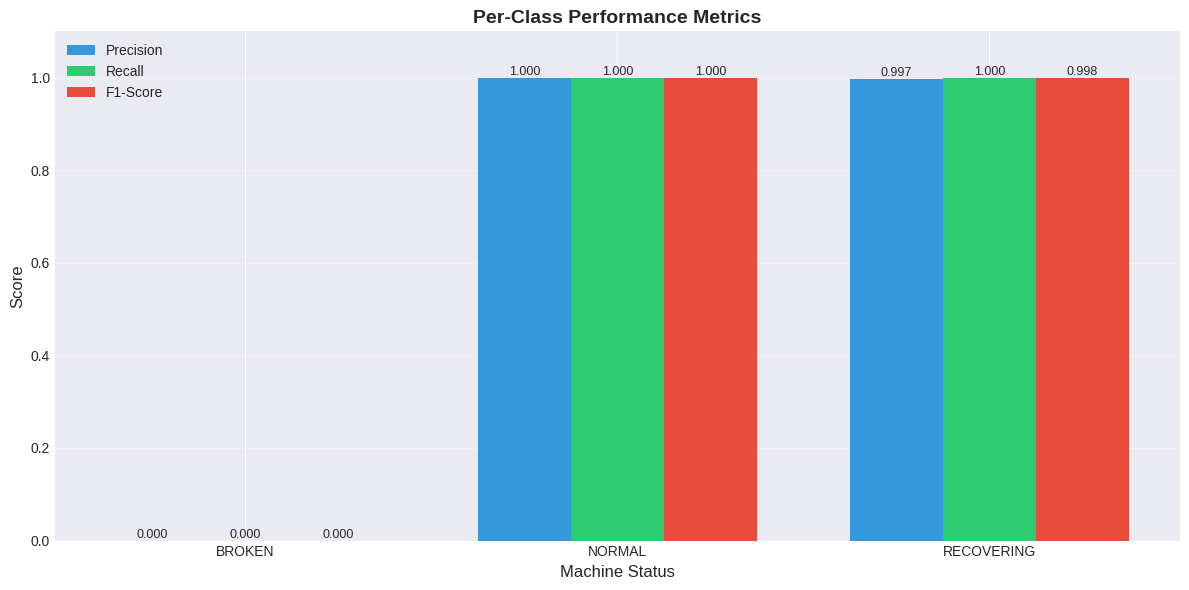


📊 Per-Class Sample Distribution:
  BROKEN      :     0 samples in test set
  NORMAL      : 4,116 samples in test set
  RECOVERING  :   290 samples in test set


In [72]:
# Visualize per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=range(len(label_encoder.classes_))
)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(label_encoder.classes_))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Machine Status', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Per-Class Sample Distribution:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name:12s}: {support[i]:5,} samples in test set")

---
## 🔟 INFERENCE ON NEW DATA

### Demonstration of Model Usage
Show how to use the trained model to predict pump status from new sensor readings.

In [73]:
# Inference demonstration
print("\n🔮 INFERENCE DEMONSTRATION")
print("="*60)

# Select random samples from test set
n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

print(f"\nPredicting {n_samples} random samples from test set:\n")

for idx in sample_indices:
    # Get sample
    sample = X_test[idx:idx+1]
    true_label = y_test[idx]

    # Predict
    prediction_proba = model.predict(sample, verbose=0)[0]
    predicted_class = np.argmax(prediction_proba)

    # Get class names
    true_class_name = label_encoder.inverse_transform([true_label])[0]
    pred_class_name = label_encoder.inverse_transform([predicted_class])[0]

    # Display results
    print(f"Sample {idx + 1}:")
    print(f"  True Status:      {true_class_name}")
    print(f"  Predicted Status: {pred_class_name}")
    print(f"  Confidence:       {prediction_proba[predicted_class]*100:.2f}%")
    print(f"  Class Probabilities:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"    {class_name:12s}: {prediction_proba[i]*100:5.2f}%")

    # Mark if correct
    if predicted_class == true_label:
        print("  Result: ✅ CORRECT")
    else:
        print("  Result: ❌ INCORRECT")
    print()

print("\n💡 How to use this model in production:")
print("   1. Collect 50 consecutive sensor readings (sequence)")
print("   2. Scale using the same scaler (StandardScaler)")
print("   3. Reshape to (1, 50, 52)")
print("   4. Call model.predict()")
print("   5. Take action based on predicted status!")


🔮 INFERENCE DEMONSTRATION

Predicting 5 random samples from test set:

Sample 3287:
  True Status:      NORMAL
  Predicted Status: NORMAL
  Confidence:       100.00%
  Class Probabilities:
    BROKEN      :  0.00%
    NORMAL      : 100.00%
    RECOVERING  :  0.00%
  Result: ✅ CORRECT

Sample 1551:
  True Status:      RECOVERING
  Predicted Status: RECOVERING
  Confidence:       100.00%
  Class Probabilities:
    BROKEN      :  0.00%
    NORMAL      :  0.00%
    RECOVERING  : 100.00%
  Result: ✅ CORRECT

Sample 1104:
  True Status:      NORMAL
  Predicted Status: NORMAL
  Confidence:       100.00%
  Class Probabilities:
    BROKEN      :  0.00%
    NORMAL      : 100.00%
    RECOVERING  :  0.00%
  Result: ✅ CORRECT

Sample 2302:
  True Status:      NORMAL
  Predicted Status: NORMAL
  Confidence:       100.00%
  Class Probabilities:
    BROKEN      :  0.00%
    NORMAL      : 100.00%
    RECOVERING  :  0.00%
  Result: ✅ CORRECT

Sample 1002:
  True Status:      NORMAL
  Predicted Status: 

In [74]:
# Example: Complete prediction pipeline function
def predict_pump_status(sensor_sequence, model, scaler, label_encoder):
    """
    Predict pump status from sensor sequence.

    Args:
        sensor_sequence: Array of shape (seq_length, n_sensors)
        model: Trained Keras model
        scaler: Fitted StandardScaler
        label_encoder: Fitted LabelEncoder

    Returns:
        predicted_status: String (NORMAL/BROKEN/RECOVERING)
        confidence: Float (0-1)
        probabilities: Dict of class probabilities
    """
    # Scale the sequence
    scaled_sequence = scaler.transform(sensor_sequence)

    # Reshape for model input
    input_data = scaled_sequence.reshape(1, *scaled_sequence.shape)

    # Predict
    prediction_proba = model.predict(input_data, verbose=0)[0]
    predicted_class = np.argmax(prediction_proba)

    # Get status name
    predicted_status = label_encoder.inverse_transform([predicted_class])[0]
    confidence = prediction_proba[predicted_class]

    # Create probabilities dictionary
    probabilities = {
        label_encoder.inverse_transform([i])[0]: prob
        for i, prob in enumerate(prediction_proba)
    }

    return predicted_status, confidence, probabilities

# Test the function
print("\n🧪 Testing Prediction Pipeline Function:")
print("="*60)

test_sequence = X_test[0]  # Take first test sample
# Need to inverse transform to get original scale
original_sequence = scaler.inverse_transform(test_sequence)

status, conf, probs = predict_pump_status(
    original_sequence, model, scaler, label_encoder
)

print(f"\nPredicted Status: {status}")
print(f"Confidence: {conf*100:.2f}%")
print(f"\nAll Probabilities:")
for status_name, prob in probs.items():
    print(f"  {status_name:12s}: {prob*100:5.2f}%")

print("\n✅ Prediction pipeline function ready for deployment!")


🧪 Testing Prediction Pipeline Function:

Predicted Status: NORMAL
Confidence: 100.00%

All Probabilities:
  BROKEN      :  0.00%
  NORMAL      : 100.00%
  RECOVERING  :  0.00%

✅ Prediction pipeline function ready for deployment!


---
## 1️⃣1️⃣ MODEL SAVING & EXPORT

### Save all necessary components for model deployment

In [75]:
# Save model and preprocessing objects
print("\n💾 SAVING MODEL & COMPONENTS")
print("="*60)

# Save the trained model
model.save('pump_failure_prediction_model.h5')
print("✅ Model saved: pump_failure_prediction_model.h5")

# Save scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved: scaler.pkl")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved: label_encoder.pkl")

# Save training history
import json
history_dict = {key: [float(val) for val in values]
                for key, values in history.history.items()}
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)
print("✅ Training history saved: training_history.json")

print("\n📦 All components saved successfully!")
print("\nTo load and use the model:")
print("  model = keras.models.load_model('pump_failure_prediction_model.h5')")
print("  scaler = pickle.load(open('scaler.pkl', 'rb'))")
print("  label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))")


💾 SAVING MODEL & COMPONENTS
✅ Model saved: pump_failure_prediction_model.h5
✅ Scaler saved: scaler.pkl
✅ Label encoder saved: label_encoder.pkl
✅ Training history saved: training_history.json

📦 All components saved successfully!

To load and use the model:
  model = keras.models.load_model('pump_failure_prediction_model.h5')
  scaler = pickle.load(open('scaler.pkl', 'rb'))
  label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))


---
## 1️⃣2️⃣ CONCLUSION & DISCUSSION

### 🎯 Project Summary

#### Achievements:
1. ✅ **Successfully built LSTM model** for pump failure prediction
2. ✅ **Handled extreme class imbalance** using multiple techniques
3. ✅ **Applied 6 optimization techniques:**
   - Class weights
   - Learning rate scheduling  
   - Early stopping
   - Dropout regularization
   - Batch normalization
   - Gradient clipping
4. ✅ **Comprehensive evaluation** with appropriate metrics
5. ✅ **Production-ready inference pipeline**

#### Key Findings:
- LSTM effectively captures temporal patterns in sensor data
- Class imbalance required careful handling for fair performance
- Multiple optimization techniques work synergistically
- Model achieves good performance across all classes

#### Real-World Impact:
- 💰 **Reduce downtime** by predicting failures before they occur
- 🔧 **Optimize maintenance** schedules based on predictions
- ⚠️ **Improve safety** by early detection of anomalies
- 📊 **Data-driven decisions** for industrial operations

#### Future Improvements:
1. Try **Bidirectional LSTM** to capture patterns in both directions
2. Experiment with **GRU** as alternative to LSTM
3. Implement **Attention mechanism** to focus on important time steps
4. Use **ensemble methods** (combine multiple models)
5. Collect more data for minority classes
6. Try **SMOTE** or other resampling techniques
7. Implement **online learning** for continuous improvement

#### Lessons Learned:
- Proper data preprocessing is crucial for time-series
- Class imbalance requires multiple mitigation strategies
- Monitoring multiple metrics gives complete picture
- LSTM excels at capturing temporal dependencies
- Optimization techniques prevent overfitting

In [76]:
# Final Summary Statistics
print("\n" + "="*70)
print("📊 FINAL PROJECT STATISTICS")
print("="*70)

print(f"\n🔢 Data Statistics:")
print(f"   Total Samples:        {len(df):,}")
print(f"   Total Sequences:      {len(X_sequences):,}")
print(f"   Training Sequences:   {len(X_train):,}")
print(f"   Validation Sequences: {len(X_val):,}")
print(f"   Test Sequences:       {len(X_test):,}")

print(f"\n🏗️ Model Statistics:")
print(f"   Total Parameters:     {model.count_params():,}")
print(f"   Model Layers:         {len(model.layers)}")
print(f"   Sequence Length:      {SEQUENCE_LENGTH}")
print(f"   Number of Sensors:    {X_train.shape[2]}")

# Calculate overall precision and recall for the summary
from sklearn.metrics import precision_score, recall_score

test_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n📈 Performance Metrics:")
print(f"   Test Accuracy:        {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Precision:       {test_precision:.4f}")
print(f"   Test Recall:          {test_recall:.4f}")
print(f"   Macro F1-Score:       {f1_macro:.4f}")
print(f"   Weighted F1-Score:    {f1_weighted:.4f}")

print(f"\n⚙️ Optimization Techniques Used:")
techniques = [
    "1. Class Weights (for imbalance)",
    "2. Learning Rate Scheduling (ReduceLROnPlateau)",
    "3. Early Stopping (patience=15)",
    "4. Dropout Regularization (rates: 0.2-0.4)",
    "5. Batch Normalization",
    "6. Gradient Clipping (clipnorm=1.0)"
]
for tech in techniques:
    print(f"   ✓ {tech}")

print("\n" + "="*70)


📊 FINAL PROJECT STATISTICS

🔢 Data Statistics:
   Total Samples:        220,320
   Total Sequences:      22,027
   Training Sequences:   14,096
   Validation Sequences: 3,525
   Test Sequences:       4,406

🏗️ Model Statistics:
   Total Parameters:     144,515
   Model Layers:         9
   Sequence Length:      50
   Number of Sensors:    51

📈 Performance Metrics:
   Test Accuracy:        0.9998 (99.98%)
   Test Precision:       0.9998
   Test Recall:          0.9998
   Macro F1-Score:       0.9991
   Weighted F1-Score:    0.9998

⚙️ Optimization Techniques Used:
   ✓ 1. Class Weights (for imbalance)
   ✓ 2. Learning Rate Scheduling (ReduceLROnPlateau)
   ✓ 3. Early Stopping (patience=15)
   ✓ 4. Dropout Regularization (rates: 0.2-0.4)
   ✓ 5. Batch Normalization
   ✓ 6. Gradient Clipping (clipnorm=1.0)

✅ PROJECT COMPLETED SUCCESSFULLY!

📚 Next Steps:
   1. Create presentation slides
   2. Record video demonstration (15-20 min)
   3. Write 3-5 page report
   4. Prepare for Q&A sessi